In [103]:
%matplotlib inline
import scipy
import sympy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from modsim import*

R = 51
L = 25
C0 = 220 * (10 ** (-3))

condition = Condition(R = R,
                      L = L, 
                      C0 = C0, 
                      V0 = 9, # Standard battery is 5V, 9V and 13.8V
                      dV0dt = 0,
                      f0 = 1073.02, 
                      w0 = 1 / sqrt(L * C0))

In [104]:
duration = 300

dt = 1

ts = linrange(0, duration, dt)

In [105]:
def make_system(condition):
    
    unpack(condition)
    
    init = State(X1 = V0, X2 = dV0dt)
    
    system = System(init=init, R=R, L=L, C0=C0, V0=V0, dV0dt=dV0dt, f0=f0, w0=w0, ts=ts)
    
    return system
                    
    
circuit = make_system(condition)

In [106]:
def slope_func(state, t, circuit):
    
    X1, X2 = state
    unpack(circuit)
    
    dX1dt = X2
    # dX2dt = ((L/R*C0) * (V0*np.degrees(np.sin(w0*t))) - ((1/R*L*C0)*X1) - ((1/L)*X2))
    # Used w0 in radians to get better results
    dX2dt = ((L/R*C0) * (V0*math.sin((w0)*t)) - ((1/R*L*C0)*X1) - ((1/L)*X2)) 
    
    return dX1dt, dX2dt

slope_func(circuit.init, 0, circuit) # Testing

(0.0, -0.97058823529411753)

In [107]:
run_odeint(circuit, slope_func, mxstep=5000)

# circuit.results

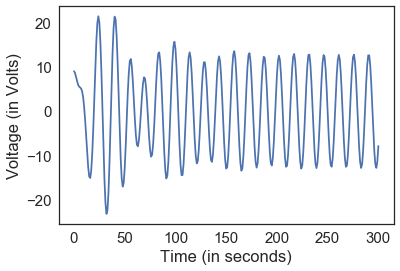

In [108]:
X1 = circuit.results.X1 # voltage
X2 = circuit.results.X2 # first derivative
X3 = (X2.diff()/dt) # second derivative
plt.plot(ts, X1)
#plot(ts, X1, '.')
xlabel("Time (in seconds)")
ylabel("Voltage (in Volts)")
#savefig('V vs Time.svg')

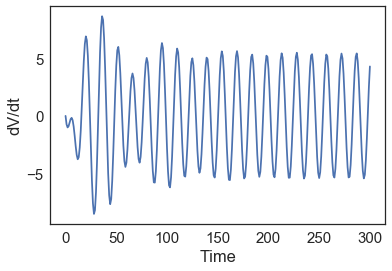

In [109]:
plt.plot(ts, X2)
xlabel("Time")
ylabel("dV/dt")
#savefig('dVdt vs Time.svg')

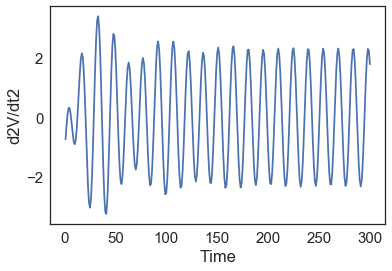

In [110]:
plt.plot(ts, X3)
xlabel("Time")
ylabel("d2V/dt2")
#savefig('dVdt2 vs Time.svg')

In [168]:
def getAmp(X1, ts):
    
    min = 10000
    max = -5
    
    for i in range(len(X1)):
        
        t = ts[i]
        x = X1[i]
        
        if t > 180 and t < 300:
            
            if x > max:
                max = x
            
            if x < min:
                min = x
                
    Amp = (max - min)
    
    return Amp    

In [169]:
getAmp(X1, ts)

25.853824304123265

In [170]:
def run_simulation(w0):
    
    condition.w0 = w0
    #print(condition)
    
    circuit = make_system(condition)
    run_odeint(circuit, slope_func)
    X3 = (circuit.results.X2.diff()/dt)
    amp = getAmp(X3, ts)
    
    return amp
    

In [171]:
run_simulation(w0)

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.34344403460690709

In [172]:
def loopy_boi():
    
    C_min = (9.017 * 10**(-8))
    C_max = (1.369 * 10**(-7))
    # w0_array = linspace(6, 13, 100) # 0 to 10 for the glitch
    C_array = linspace(C_min, C_max, 200) 
    #print(C_array)
    w0_array = 1 / (sqrt(L * C_array)) # 138.2300 min, 169.6460 max
    
    amps = []
    for w0 in w0_array:
        #print(w0_array)
        amp = run_simulation(w0)
        amps.append(amp)
        #print(amp)
    #print(w0_array)    
    return (w0_array, amps)

In [173]:
(w0_array, amp_array) = loopy_boi()
print(amp_array)

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\algorithms.py:1635: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


[1.0163378033737955e+294, 6.226811002187892e+179, 0.018404868401374598, 5.0435903431909272e+304, 0.018404868401374598, 0.014930705434101734, 0.34344403460690709, 1.0163378033737955e+294, 6.226811002187892e+179, 0.34344403460690709, 1.0163378033737955e+294, 0.046966859461191425, 0.050418425495858718, 0.018404868401374598, 0.014930705434101734, 0.34344403460690709, 1.0163378033737955e+294, 0.050418425495858718, 0.046966859461191425, 0.050418425495858718, 0.34344403460690709, 1.0163378033737955e+294, 0.011428780853549902, 0.0096683657730044469, 0.34344403460690709, 1.0163378033737955e+294, 0.011428780853549902, 0.050418425495858718, 0.014930705434101734, 0.34344403460690709, 1.0163378033737955e+294, 0.011428780853549902, 0.050418425495858718, 1.0972253410437808e+304, 1.4522533324225211e+308, 5.2884477503219888e+125, 2.9740338391138448e+284, 1.3670987652222228e+125, 1.3669090109844729e+125, 0.0, 1.4522533324225211e+308, 1.3670987652222228e+125, 5.2884477503219888e+125, 1.3669397954641263e+

In [174]:
Frequency = w0_array/(2*pi)
Amplitude = amp_array/V0

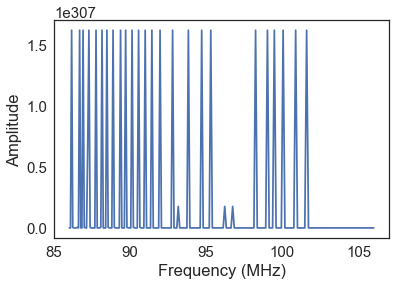

In [175]:
plt.plot(Frequency, Amplitude) 
#plot(w0_array, amp_array, '.')
xlabel("Frequency (MHz)")
ylabel("Amplitude")
#savefig('Bode Plot 3.pdf')
#print(amp_array)

In [ ]:
#w0_array[amp_array.index(0.093995685536970852)]

In [ ]:
condition.w0 = 3.131313131313131
slope_func(circuit.init, 0, circuit)
run_odeint(circuit, slope_func)

X1 = circuit.results.X1 # voltage
X2 = circuit.results.X2 # first derivative
X3 = (X2.diff()/dt) # second derivative

plot(ts, X3)
getAmp(X3, ts)

"""When I ran ODEINT with all the values of w0, it gave me a rogue datapoint. I went in and ran ODEINT for that particular
    datapoint and then ODEINT gave a different, valid datapoint for that particular point. So that means ODEINT is not
    behaving properly when I run multiple iterations of w0 through it."""

In [ ]:
# DO NOT EVER RUN THIS CELL
#goodRunW0 = w0_array
#goodRunAmp = amp_array

goodRun = pd.Series(goodRunAmp, index=goodRunW0)
goodRun.to_csv("goodrun.csv")
#plt.plot(goodRunW0, goodRunAmp)
plot(goodRun)

In [ ]:
def loopy_boi(condition, system, slope_func):
    
    w0_array = linrange(1, 2, 10)

    w0_frame = []

    for w0 in w0_array:

        #condition = Condition(R = 51, L = 4, C0 = 220 * (10 ** (-3)), V0 = 5, dV0dt = 0, f0 = 1073.02, w0 = 1)
        condition.w0 = (w0)
        circuit = make_system(condition)
        slope_func(circuit.init, 0, circuit)
        run_odeint(circuit, slope_func)
        w0_frame.append(X3)
        
        return w0_frame

        #circuit.results

In [ ]:
loopy_boi(condition, circuit, slope_func)